# Intro Task, Object Localization

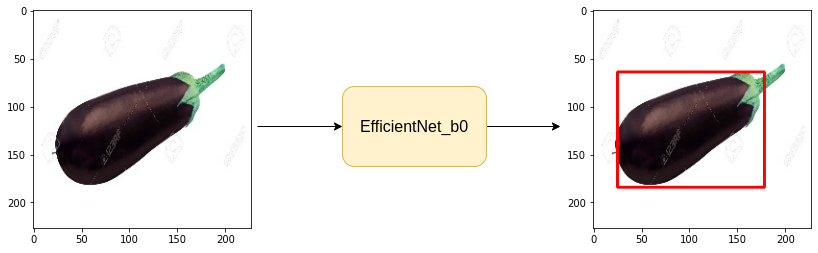

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ddcupi4i
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ddcupi4i
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=e071f7e2ace1b8059c661b68b208db3a4b05fb4e6ac36bfe4b13fd0bc856149a
  Stored in directory: /tmp/pip-ephem-wheel-cache-1977vn6o/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 5.80 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001 #LEARNING RATE
EPHOCS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4 # COORDINATES

In [ ]:
# READ THE CSV FILE
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

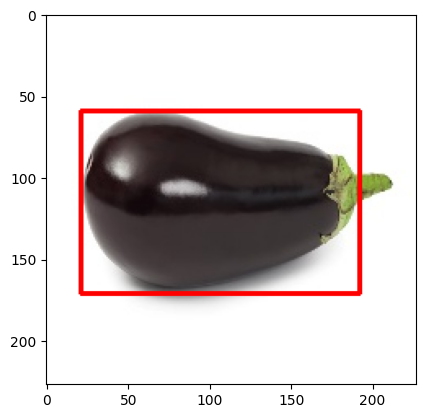

In [ ]:
# Plot some of the images form the dataset
row = df.iloc[184] # select example number 2
img = cv2.imread(DATA_DIR + row.img_path) # read the image using opencv imread
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert BGR to RGB

# show the bounding box
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2)
plt.imshow(bnd_box_img)

In [ ]:
# Split the dataset into training and validation sets
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [ ]:
import albumentations as A  # well-known library for data augmentation tasks

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip( p=0.5 ),
    A.VerticalFlip( p=0.5 ),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'] ))



In [ ]:
valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'] ))



# Create Custom Dataset

In [ ]:
class ObjLocDataset( torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    # get coordinates
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    # create bbox
    bbox = [[xmin, ymin, xmax, ymax]] #albumention requires list of list as bbox

    # create image with bounding box
    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels=[None]) # as we are not doing classification, so we put None as class_labels
      img = data['image']
      bbox = data['bboxes'][0] # get access to list of list

    img = torch.from_numpy(img).permute(2, 0, 1)/255.0 # permute transform(h, w, c) -> (c, h, w) as pytorch required convention
    bbox = torch.Tensor(bbox)

    return img, bbox


In [ ]:
# create train and valid set
trainset = ObjLocDataset( train_df, train_augs )
validset = ObjLocDataset( valid_df, valid_augs )


In [ ]:
print(f"Total examples in the Train Set: {len(trainset)}")
print(f"Total examples in the Valid Set: {len(validset)}")

Total examples in the Train Set: 148
Total examples in the Valid Set: 38


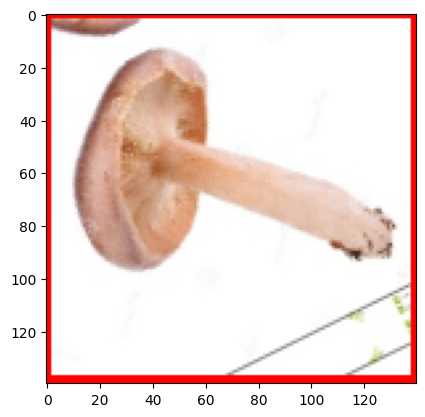

In [ ]:
img, bbox = trainset[120]

#unpack the bbox
xmin, ymin, xmax, ymax = bbox

# create points for rectangle
pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

# convert (h,w,c) convention for Numpy array
bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader( trainset, batch_size = BATCH_SIZE, shuffle = True )
validloader = torch.utils.data.DataLoader( validset, batch_size = BATCH_SIZE, shuffle = True )

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
# load a single batch

for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape)) #batch_number, channel, h, w
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
# Class to load a model
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model( MODEL_NAME, pretrained = True, num_classes = 4) # mostly return logit

  def forward( self, images, gt_bboxes = None):
    bboxes = self.backbone(images) # logit value of bboxes

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [ ]:
model = ObjLocModel()
#transfer model to GPU
model.to(DEVICE); # put semicolon to suppress the architecture text

In [ ]:
randm_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(randm_img).shape


torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() # specify the model in the training mode....Dropout layer should be ON

  for data in tqdm(dataloader): #tqdm to track the batches
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes) # predicted bbox and loss
    #gradient calculation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    total_loss += loss.item()

  return total_loss/len(dataloader)

In [ ]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval() # specify the model in the training mode....Dropout layer should be OFF

  with torch.no_grad(): # disable gardient caculation inside eval function
    for data in tqdm(dataloader): #tqdm to track the batches
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes) # predicted bbox and loss
      total_loss += loss.item()

  return total_loss/len(dataloader)

#Training Loop

In [ ]:
#declare the optimizer
optimizer = torch.optim.Adam( model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf # initial validation loss

for i in range(EPHOCS):

  train_loss = train_fn( model, trainloader, optimizer)
  valid_loss = eval_fn( model, validloader)

  if valid_loss < best_valid_loss: # save better model
    torch.save(model.state_dict(), 'best_model.pt')
    print("WEIGHTS_ARE-SAVED")
    best_valid_loss = valid_loss

  print(f"Epoch: {i + 1} train loss : {train_loss} valid loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 1 train loss : 5208.28720703125 valid loss : 4447.301839192708


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 2 train loss : 2065.3904663085937 valid loss : 1898.4652506510417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 3 train loss : 1199.6955200195312 valid loss : 224.62531026204428


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4 train loss : 806.6393920898438 valid loss : 245.84171549479166


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 5 train loss : 550.6492340087891 valid loss : 164.51339213053384


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 train loss : 392.32421875 valid loss : 199.58109537760416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 train loss : 319.0072937011719 valid loss : 172.48538208007812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 train loss : 223.7891067504883 valid loss : 176.0433146158854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 9 train loss : 185.33541870117188 valid loss : 142.54183451334634


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 train loss : 162.4746223449707 valid loss : 171.4919230143229


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 11 train loss : 132.83303146362306 valid loss : 115.44991556803386


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 12 train loss : 91.44992065429688 valid loss : 96.43579355875652


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 13 train loss : 91.09247093200683 valid loss : 93.44968032836914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 14 train loss : 90.1569709777832 valid loss : 84.1491928100586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 train loss : 91.76565322875976 valid loss : 96.87628682454427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 train loss : 79.6816234588623 valid loss : 96.90714263916016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 train loss : 75.33206710815429 valid loss : 92.47924296061198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 train loss : 66.82648468017578 valid loss : 121.74281819661458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 19 train loss : 70.83114509582519 valid loss : 60.25680923461914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 train loss : 69.77675170898438 valid loss : 64.94277699788411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 train loss : 69.51231117248535 valid loss : 96.95154825846355


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 22 train loss : 69.53561134338379 valid loss : 50.38689041137695


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 train loss : 58.439761543273924 valid loss : 52.94928232828776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 train loss : 43.85841827392578 valid loss : 63.1047108968099


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 25 train loss : 58.346075439453124 valid loss : 37.29094441731771


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 train loss : 58.51675033569336 valid loss : 41.33049774169922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 train loss : 55.72170066833496 valid loss : 40.84790929158529


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 train loss : 48.430931091308594 valid loss : 41.27592468261719


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 train loss : 60.88340396881104 valid loss : 64.228271484375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 train loss : 48.01717586517334 valid loss : 52.76963551839193


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 train loss : 48.36492023468018 valid loss : 61.269962310791016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 train loss : 42.50744285583496 valid loss : 51.74350229899088


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 train loss : 53.86770172119141 valid loss : 46.79400889078776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS_ARE-SAVED
Epoch: 34 train loss : 42.0159294128418 valid loss : 32.050994237264


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 train loss : 42.79281387329102 valid loss : 35.461268742879234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 train loss : 38.47861576080322 valid loss : 56.540627797444664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 train loss : 43.852664947509766 valid loss : 42.3383903503418


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 train loss : 77.09199028015136 valid loss : 48.27914810180664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 train loss : 74.77800922393799 valid loss : 61.96561050415039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 train loss : 44.759667587280276 valid loss : 56.04145812988281


#Inference

In [ ]:
import utils

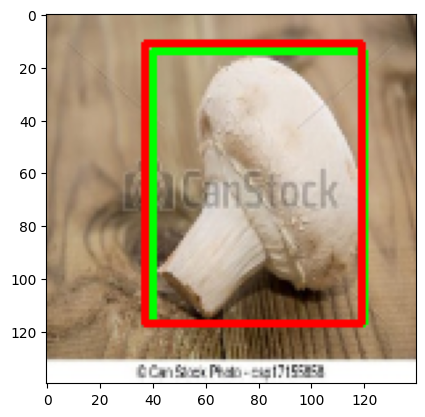

In [ ]:
# compare gt_bbox with pred_bbox
model.load_state_dict(torch.load('best_model.pt')) # load saved best modle
model.eval()

with torch.no_grad():

  image, gt_bbox = validset[23] # (c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (bs, c, h, w)
  out_bbox = model(image) #predicted bbox

  utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya